In [40]:
# imports
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import pyplot as plt
import pylab

from scipy.cluster.hierarchy import cophenet, linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist

%run 'parse.ipynb'
#%matplotlib inline
%matplotlib notebook

In [2]:
# load data
s = [parse(data_type='training', subj=i) for i in range(1,21)] # train

In [63]:
def reordered_corrplot(C, metric='correlation'):
    Z = linkage(C, 'single', metric)
    D = dendrogram(Z, orientation='right')
    axmatrix = fig.add_axes([0.3,0.1,0.6,0.8])
    
    index = D['leaves']
    
    C = C[index,:]
    C = C[:,index]
    
    im = axmatrix.matshow(C, aspect='auto', origin='lower')
    axmatrix.set_xticks([])
    axmatrix.set_yticks([])

    # Plot colorbar.
    axcolor = fig.add_axes([0.91,0.1,0.02,0.8])
    pylab.colorbar(im, cax=axcolor)

    # Display and save figure.
    fig.show()
    return index
    
# Average ...

(279, 279)


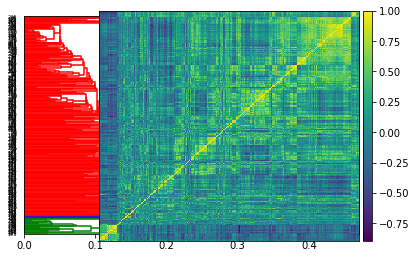

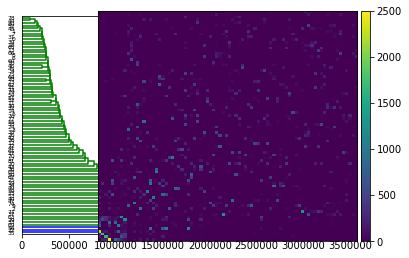

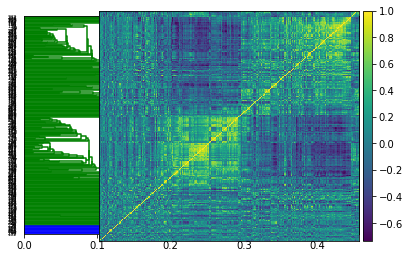

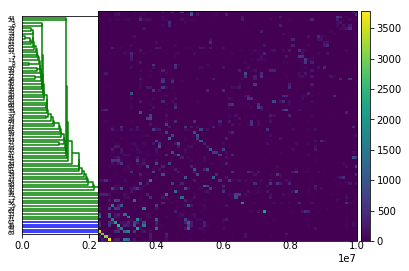

In [13]:
fig = plt.figure()
print s[0]['Pre_RS'].shape
C = s[0]['Pre_RS'].as_matrix()[1:,1:]
reordered_corrplot(C)
                   
fig=plt.figure()
C2 = s[1]['Pre_FS'].as_matrix()
reordered_corrplot(C2, 'sqeuclidean')

fig = plt.figure()
C = s[2]['Pre_RS'].as_matrix()[1:, 1:]
reordered_corrplot(C)

fig=plt.figure()
C2 = s[3]['Pre_FS'].as_matrix()
reordered_corrplot(C2, 'sqeuclidean')

In [38]:
C = np.nansum([s[i]['Pre_RS'].as_matrix()[:,1:] for i in range(20)], axis=0) / 20.0

[114,
 157,
 29,
 260,
 175,
 166,
 219,
 117,
 232,
 177,
 67,
 174,
 57,
 143,
 201,
 238,
 103,
 230,
 112,
 216,
 113,
 150,
 24,
 262,
 100,
 163,
 60,
 251,
 259,
 51,
 272,
 10,
 154,
 72,
 41,
 97,
 127,
 148,
 38,
 235,
 158,
 133,
 93,
 5,
 71,
 186,
 192,
 220,
 66,
 137,
 65,
 48,
 271,
 173,
 210,
 125,
 140,
 75,
 12,
 30,
 193,
 200,
 53,
 160,
 109,
 85,
 161,
 202,
 73,
 162,
 89,
 8,
 39,
 78,
 195,
 183,
 63,
 136,
 179,
 258,
 124,
 115,
 19,
 34,
 40,
 145,
 231,
 59,
 223,
 54,
 229,
 44,
 87,
 139,
 58,
 228,
 131,
 189,
 164,
 126,
 244,
 276,
 275,
 171,
 196,
 96,
 110,
 79,
 239,
 242,
 86,
 108,
 249,
 152,
 83,
 207,
 222,
 116,
 155,
 226,
 52,
 269,
 11,
 13,
 167,
 274,
 35,
 107,
 204,
 105,
 213,
 22,
 221,
 234,
 184,
 119,
 101,
 246,
 120,
 95,
 256,
 84,
 16,
 194,
 215,
 26,
 172,
 81,
 268,
 146,
 28,
 156,
 159,
 6,
 241,
 253,
 165,
 99,
 7,
 56,
 92,
 0,
 4,
 205,
 33,
 49,
 153,
 138,
 277,
 27,
 3,
 147,
 104,
 252,
 254,
 31,
 261,
 70,
 26

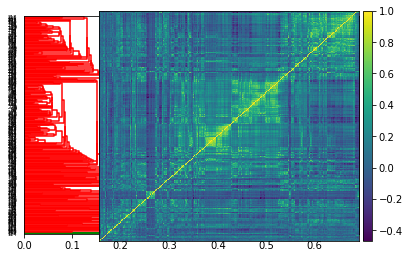

In [64]:
fig = plt.figure()
reordered_corrplot(C,)

In [43]:
locs = s[0]['XYZ'].loc[range(1,279),('X','Y','Z')].as_matrix()

<IPython.core.display.Javascript object>


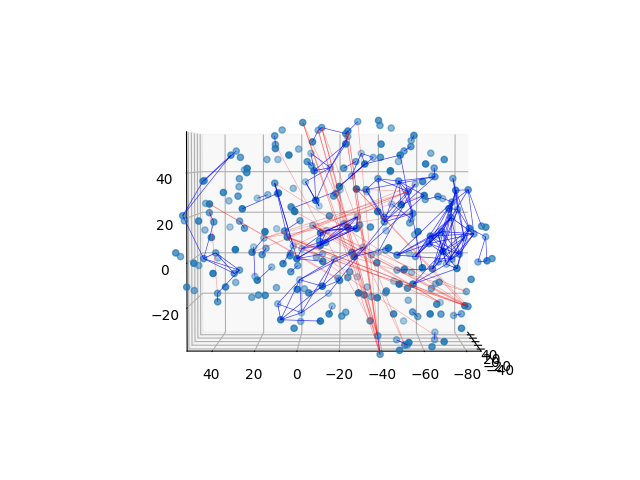

In [65]:
#def conn_plot(C, locs):
#%matplotlib inline
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.scatter(locs[:,0], locs[:,1], locs[:,2])

blue = (0.0,0.0,1.0)
red = (1.0,0.0,0.0)

p1s = []
p2s = []
cols = []

# connections
for i in range(278):
    for j in range(i,278):
        if C[i,j]>0.7 or C[i,j] < -0.3: #draw-thresh
            p1s.append(locs[i])
            p2s.append(locs[j])
            col = blue if C[i,j]>0 else red
            col = col + tuple((abs(C[i,j]),))
            cols.append(col)

ls = np.hstack([p1s, p2s]).copy()
ls = ls.reshape((-1,2,3))

lc = Line3DCollection(ls, linewidths=0.5, colors=cols)
ax.add_collection(lc)

In [39]:
C.shape

(278, 278)

In [44]:
locs

array([[ 53,   5,  22],
       [ 15,  32,  50],
       [ 11,  53, -16],
       [ 35, -24,  57],
       [ 57, -20,  31],
       [ 29,  52,  -5],
       [ 26,  -9,  60],
       [ 31, -37,  47],
       [ 25,  17,  46],
       [ 55, -14, -20],
       [  5, -13,   7],
       [  9, -76,  -1],
       [ 13, -54, -42],
       [  8, -87,  11],
       [ 37, -22,  15],
       [  6, -67,  42],
       [ 58, -34,  30],
       [ 48, -29,  18],
       [ 58, -29, -12],
       [ 46,  37,  13],
       [  6, -54,  31],
       [  8,  24, -19],
       [ 47, -71,   9],
       [ 48, -59,  34],
       [ 12,  17,   4],
       [ 46,   0, -29],
       [  6,  11,  30],
       [ 45, -15,  42],
       [ 24, -46,  61],
       [ 11, -43, -17],
       [ 31, -49, -41],
       [ 19, -29,  64],
       [ 62, -40,   0],
       [ 52,  -2,  35],
       [ 54, -56,   0],
       [ 19, -77,  37],
       [ 13,  60,   0],
       [ 28, -78, -29],
       [ 43, -73,  27],
       [ 33, -67,  38],
       [  6, -52,  50],
       [ 30, -36